In [20]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from scipy.stats import ttest_ind

# **Part 2: Experiment Analysis**


Julia Kang (juliakangm@gmail.com)

In [2]:
# dataset provided was renamed df.csv
df = pd.read_csv('df.csv')
df['overspend_pct'] = (df['campaign_spend'] - df['campaign_budget']) * 100. / df['campaign_budget']

In [3]:
df_control = df[df['treatment']== False]
df_treatment = df[df['treatment']== True]

## **QUESTIONS**

There’s no specific structure or style that we expect from either output other than following your usual best practices. Please ensure that any figures or tables you include are clearly labelled and all relevant constituent components are legible. The audience for your report is product manager who is familiar with data science and experimentation practices and who wants to have an in-depth understanding of the results.
1. How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?
2. Was the new product effective at reducing overspend, and was it more or less effective depending on the company size? Put together an analysis describing how the treatment affected overspend.
3. A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any differences in budgets are likely due to random fluctuations.

## **Question #1: Overspend**

**1. How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?**

Campaigns with overspend greater than 1% of budget in the control group: 5716    
Campaigns with overspend greater than 1% of budget in the treatment group: 5180

In [5]:
# 1. How many campaigns have overspend of greater than 1% of their budget in the control group? In the treatment group?

# Control Group overspend > 1% of budget: 5716
# Treatment Group overspend > 1% of budget: 5180

print('Control Group overspend > 1% of budget: ' + str(df_control[df_control['overspend_pct'] > 1.]['treatment'].count()))
print('Treatment Group overspend > 1% of budget: ' + str(df_treatment[df_treatment['overspend_pct'] > 1. ]['treatment'].count()))

Control Group overspend > 1% of budget: 5716
Treatment Group overspend > 1% of budget: 5180


## **Question #2: Product Effectiveness**

**2. Was the new product effective at reducing overspend, and was it more or less effective depending on the company size? Put together an analysis describing how the treatment affected overspend.**

### **Approach:**

1. Look at overall performance by using a one-sided t-test      
  - Compare the average overspend percentage of the treatment and control group to see if we have statistical significance

2. Segment by company size and repeat for each company size



**Hypothesis:** By charging advertisers based on each time an ad is shown to a user rather than when its clicked, we can expect a decrease in overspending because of the anticipated reduced latency between delivery and billing.

**H0:** *The overspend percent is the same between treatment and control groups.*

**Ha:** *The overspend percent is different between treatment and control groups.*

**alpha:** *0.05*

**key metric:** *overspend_pct*

In [9]:
alpha = 0.05

#  Given sufficiently large n and unknown population variance, we will use a t test to test for statistical significance. 
#  Despite the data looking slightly skewed, with large N we will rely on CLT to account for any
#  non-normality

t1, p1 = ttest_ind(df_control['overspend_pct'], df_treatment['overspend_pct'])
print('company size: all')
print("t = " + str(t1))
print("p = " + str(p1))

if p1 > alpha:
  print('Fail to reject null')
else:
  print('Reject null')
print("")

# Since the p value is less than 0.05 we can reject the null hypothesis and claim that the mean of the 
# two distributions are different and statistically significant 

company size: all
t = 6.676732178870896
p = 2.526459450693738e-11
Reject null



In [11]:
# perform t-test on data segmented by company size

df_control_dict = {}
df_treatment_dict = {}

for size, sub_df in df_control.groupby('company_size'):
  df_control_dict[size] = sub_df

for size, sub_df in df_treatment.groupby('company_size'):
  df_treatment_dict[size] = sub_df

for size in ['small', 'medium', 'large']:
  print('company size: ' + str(size))
  t2, p2 = ttest_ind(df_control_dict[size]['overspend_pct'], df_treatment_dict[size]['overspend_pct'])
  print("t = " + str(t2))
  print("p = " + str(p2))
  if p2 > alpha:
    print('Fail to reject null')
  else:
    print('Reject null')
  print("")

company size: small
t = 5.629760548364627
p = 1.859387865572712e-08
Reject null

company size: medium
t = -0.2562030814224952
p = 0.7978310093551002
Fail to reject null

company size: large
t = 6.466774927911017
p = 1.0938563786462007e-10
Reject null



### **Quick Experiment Summary**

Looking at the whole population, our p-value is essentially 0 and t > 0 so we can **reject the null hypothesis**. In other words, the new product is effective at reducing overspending.

By further segmenting, we can see that the new billing system is most effective for large companies and small companies - both of which have p-values that approach 0 and t values greater than 0. But the new product is **not effective for medium-sized companies**.

In [80]:
# create table with side by side comparison of overspending based on company size
df_summary = df.groupby(by=['treatment', 'company_size']).agg(samples=('treatment','count'),overspend_avg=('overspend_pct','mean'),overspend_med=('overspend_pct','median'),).reset_index()
df_summary_all = df.groupby(by=['treatment']).agg(samples=('treatment','count'),overspend_avg=('overspend_pct','mean'),overspend_med=('overspend_pct','median'),).reset_index()
df_true = df_summary[df_summary['treatment'] == True]
df_false = df_summary[df_summary['treatment'] == False]
df_summary_size_by_side = df_false.merge(df_true, on = 'company_size')
df_summary_size_by_side

,treatment_x,company_size,samples_x,overspend_avg_x,overspend_med_x,treatment_y,samples_y,overspend_avg_y,overspend_med_y
0,False,large,2701,12.293655,4.015523,True,2445,3.263995,2.505261
1,False,medium,735,4.557030,2.243608,True,692,5.144382,2.470825
2,False,small,4297,37.064162,12.994556,True,4604,27.096085,7.765122


In [81]:
df_summary_all

# when aggregated, we can see that the average overspend percent decreased from 25% to 17% between the control and treatment group.

,treatment,samples,overspend_avg,overspend_med
0,False,7733,25.32255,6.455069
1,True,7741,17.60635,4.626489


### **Additional observations**

By segmenting overspend percent by company size, we can see that the overspending percent was reduced in the treatment group for large and small companies (which is validated with our t-test) - droping from 12% to 3% and 37% to 27%, respectively. However, we can make an interesting observation that overspend for medium-sized companies has increased in the treatment group going from 4.5% to 5.1%.

The overspend percent for medium companies is the reverse of what we see as a whole. If we look at the median overspend percent, we can observe that the overspend percent is not as large as that of the mean. This anomoly can be attributed to a few factors. One of which can be the smaller sample size. There are only ~700 medium size companies, but thousands of small and large companies.I am also curious how a "medium" sized company is defined - it possible that there is a lot of overlap between small/medium and medium/large which is why our samples are so low and behavior is inconsistent. (I talk about this more below.)

### **Other things worth thinking about**

Given the limited data set there are few areas worth exploring before making a final decision on product effectiveness.

**1. Customer Satisfaction**

One area to look out for is overall customer statisfaction. Since we are essentially modifying the billing model for our advertisers, charging by ad delivery rather than click, we want to ensure that our advertisers still feel like they are getting their "moneys worth". 

This can be measurerd and monitored as a gaurdrail metric. For the same budget and ad in each product, our advertisers should be recieving the same user engagement/awareness.

**2. Definition of company_size**

Knowing how company size is assigned can be very valuable in making better data decisions. Company size can could be based on employee count, revenue, budget, company age, etc or even a combination of these factors. Clarity on how an advertiser is categorized can help us better understand the experiment results and how to better tailor the product to each company type's needs. 

**2. Novelty Effect**

The data we have has been collected over the span of 1 week. Which may not be enough time to account for any seasonality or novelty effects - as users and advertisers often need time to ramp up and try to better understand the how to best use the product. I also question whether 1 week is enough for certain engagement, adoption, and awareness metrics to properly mature. 

### **Final Thoughts**

Overall, it appears that the new product **is indeed effective** at reducing overspending in most cases. I would recommend the product team to continue to explore the option and the possiblity to roll out this new billing structure. 

If the team has the bandwidth, resources, and/or time I would recommend a more controlled roll-out. Perhaps starting with large companies and/or small companies to see how they react towards the product over a longer period of time. Then using the additional data collected and feedback from advertisers, the product team can iterate and improve before launching at 100%.


## **Question 3: Suspicious New User Behavior**

**3. A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any differences in budgets are likely due to random fluctuations.**

### **Approach**

We can see if there is a difference in campaign budgets between the two groups by performing another t-test. This time we are using a one-sided t-test.

**Null Hypothesis:** The null hypothesis will be that the campaign budget of the control treatment is no more than that of the campaign budget of our treatment group.

H0: Control <= Test

**Alternative Hypothesis:** The alternative hypothesis will be that the campaign budget of the control treatment is more than that of the campaign budget of our treatment group.

Ha: Control > Test

**alpha:** 0.05

We can perform these tests on all companies as well as it segmented by company size.

In [77]:
t1, p1 = ttest_ind(df_control['campaign_budget'], df_treatment['campaign_budget'])
p1 = p1/2
print('company size: all')
print("t = " + str(t1))
print("p = " + str(p1))

if p1 < alpha and t1 > 0:
  print('Reject null')
else:
  print('Fail to reject null')
print("")

df_control_dict = {}
df_test_dict = {}

for size, sub_df in df_control.groupby('company_size'):
  df_control_dict[size] = sub_df

for size, sub_df in df_treatment.groupby('company_size'):
  df_test_dict[size] = sub_df

for size in ['small', 'medium', 'large']:
  print('company size: ' + str(size))
  t2, p2 = ttest_ind(df_control_dict[size]['campaign_budget'], df_test_dict[size]['campaign_budget'])
  p2 = p2/2
  print("t = " + str(t2))
  print("p = " + str(p2))
  if p2 < alpha and t2 > 0:
    print('Reject null')
  else:
    print('Fail to reject null')
  print("")

company size: all
t = -1.4196728095175308
p = 0.07786155243121945
Fail to reject null

company size: small
t = 2.553323378723892
p = 0.005343284160711176
Reject null

company size: medium
t = 1.145686261065636
p = 0.12605867702155
Fail to reject null

company size: large
t = -2.5378622385891805
p = 0.00559122471904406
Fail to reject null



**Summary**

We see that when looking at all companies, the p-value is greater than 0.05, and therefore we **fail to reject the null hypothesis**. In other words, when looking at all companies aggregated, the average campaign budget in the treatment group is no less than that of the control group. We could even say the PM's intuition is wrong.

However, if we segment the data by company size we see that the average campaign budgets do seem to differ between control and treatment. We can calcuate more metrics to get a better understanding of what's happening.

In [72]:
# creating a side by side comparison of the campaign budgets when separated by company size

df_summary = df.groupby(by=['treatment', 'company_size']).agg(samples=('treatment','count'),budget_avg=('campaign_budget','mean'),).reset_index()
df_true = df_summary[df_summary['treatment'] == True]
df_false = df_summary[df_summary['treatment'] == False]
df_summary_size_by_side = df_false.merge(df_true, on = 'company_size')

In [73]:
# formatting and adjusting the table 

df_summary_size_by_side = df_summary_size_by_side.reindex(sorted(df_summary_size_by_side.columns), axis=1)
df_summary_size_by_side['difference'] = df_summary_size_by_side['budget_avg_y']-df_summary_size_by_side['budget_avg_x']

cols = df_summary_size_by_side.columns.tolist()
cols = cols[-3:] + cols[:-3]

df_summary_size_by_side = df_summary_size_by_side[cols]
df_summary_size_by_side

# when separate - budgets decrease for small and medium companies ( -1953 and -1730). And increase for large companies (5933)

,treatment_x,treatment_y,difference,budget_avg_x,budget_avg_y,company_size,samples_x,samples_y
0,False,True,11627.856822,5933.969191,17561.826013,large,2701,2445
1,False,True,-1730.184149,6342.855039,4612.670890,medium,735,692
2,False,True,-1953.175856,3538.655751,1585.479895,small,4297,4604


In [74]:
# looking at campaign budgets when aggregated

df_summary_all = df.groupby(by=['treatment']).agg(samples=('treatment','count'),budget_avg=('campaign_budget','mean'),).reset_index()
df_summary_all

# when agg - budgets increase by 2,260

,treatment,samples,budget_avg
0,False,7733,4641.827622
1,True,7741,6902.232566


**Comments : Simpson's Paradox**?

We are observing a case of Simpson's Paradox when it comes to campaign budgets. When aggregated, we see that the treatment group's budgets ***are not lower*** than the control group. If anything, the treatment group has budgets higher than that of the control group (\$6,902 vs \$4,641). However, once the data is separated into groups by company-size we observe the opposite (average campaign budgets ***are lower*** for the some treatment groups).


With conflicting results, it is up to us to decide how we want to look at the data - aggregated or separated. In this case, it seems to make the most sense to look at the data separated by company-size, rather than combining all data points together. This is because different company sizes may come with other influencial factors/confounding variables that the data currently is not showing. For example, smaller companies may have a lower risk tolerance than that of a large company. So as a result, smaller companies may be more resistant and passive to any feature change hence the decrease in campaign budgets. 

I would tell the product manager that their suspicions are correct for certain advertisers. From our t-test and analysis we can see that:
- **small advertisers** in the treatment group are setting budgets *less than* that of the control group
- **medium advertisers** in the treatment group are setting budgets about *equal to* that of the control group
- **large advertisers** in the treatment group are setting budgets *greater than* that of the control group


The PM can leverage surveys, write-ins, or account managers to gather feedback from our advertisers to further validate the suspicion that the advertsiers are wary about the new product.

## **Appendix**

### **EDA: Exploratory Data Analysis**

#### **Data Definitions**

**treatment**    
bool   
If true, the campaign is using the new product. If false, it is using the old product.
      
**company_size**  
categorical    
A small company is typically a local business, a medium company is a smaller national brand (e.g. Dell Computers), and a large company is a global brand (e.g. McDonalds). This is included because businesses of different sizes use Twitter ads in very different ways and may react differently to the new product.

**campaign_spend**   
decimal    
Campaign spend during the experiment 

**campaign_budget**   
decimal    
Campaign budget during the experiment

### **Data Distribution**

The typical percent of overspend is skewed right with a few outliers of extreme overspending. If the account with high overspending is further segmented by company size, we see that small companies experience the highest overspending %. This is most likely because smaller companies have smaller budgets. So even if the amount overspent is less than those of other businesses, it will appear larger when calculated as a percentage.  

Since these outliers are seen in both the control and treatment groups, we will make the assumption that the outliers are not caused by the product feature itself and keep them included in the data set.

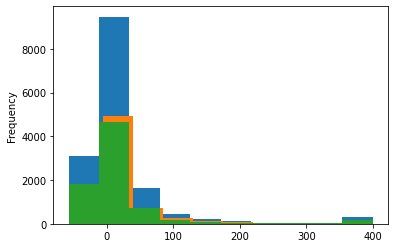

In [12]:
df['overspend_pct'].plot.hist()
df_control['overspend_pct'].plot.hist()
df_treatment['overspend_pct'].plot.hist()

In [13]:
# df_treatment.describe()
# df_control.head()

In [14]:
df[df['overspend_pct'] > 300].groupby(by = ['treatment','company_size'])['campaign_budget'].count().reset_index()

,treatment,company_size,campaign_budget
0,False,large,27
1,False,medium,3
2,False,small,176
3,True,large,16
4,True,medium,4
5,True,small,152


In [15]:
df.groupby('company_size').agg(samples = ('treatment','count'), avg_budget_amount= ('campaign_budget','mean'), avg_spend_amount = ('campaign_spend','mean'))

,samples,avg_budget_amount,avg_spend_amount
company_size,,,
large,5146,11458.669916,9523.545908
medium,1427,5503.830910,4086.094606
small,8901,2528.384810,2362.719570


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


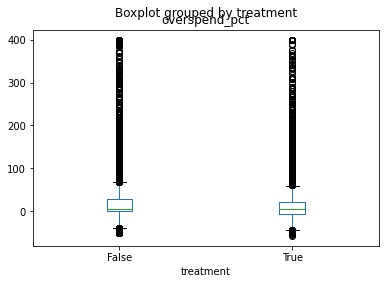

In [16]:
df.boxplot(by ='treatment', column =['overspend_pct'], grid = False) 

In [17]:
# metric exploration
control_budget_mean = df_control['campaign_budget'].mean()
control_budget_std = df_control['campaign_budget'].std()
control_spend_mean = df_control['campaign_spend'].mean()
control_spend_std = df_control['campaign_spend'].std()
print('control budget mean: ' + str(control_budget_mean))
print('control budget std: ' + str(control_budget_std))
print('control spend mean: ' + str(control_spend_mean))
print('control spend std: ' + str(control_spend_std))
print("")

control_count = df_control['campaign_budget'].count()
control_overspend_count = str(df_control[df_control['overspend_pct'] > 1.]['treatment'].count())
control_percent_overspend = float(control_overspend_count) * 100. / control_count
print('control brand count: ' + str(control_count))
print('control overspend count: ' + str(control_overspend_count))
print('control percent overspend: ' + str(control_percent_overspend))
print("")

treatment_budget_mean = df_treatment['campaign_budget'].mean()
treatment_budget_std = df_treatment['campaign_budget'].std()
treatment_spend_mean = df_treatment['campaign_spend'].mean()
treatment_spend_std = df_treatment['campaign_spend'].std()
print('treatment budget mean: ' + str(treatment_budget_mean))
print('treatment spend std: ' + str(treatment_budget_std))
print('treatment spend mean: ' + str(treatment_spend_mean))
print('treatment spend std: ' + str(treatment_spend_std))
print("")

treatment_count = df_treatment['campaign_budget'].count()
treatment_overspend_count = str(df_treatment[df_treatment['overspend_pct'] > 1.]['treatment'].count())
treatment_percent_overspend = float(treatment_overspend_count) * 100. / treatment_count
print('treatment brand count: ' + str(treatment_count))
print('treatment overspend count: ' + str(treatment_overspend_count))
print('treatment percent overspend: ' + str(treatment_percent_overspend))
print("")

control budget mean: 4641.827621712152
control budget std: 47765.75379742044
control spend mean: 3950.849714147173
control spend std: 34024.71002591698

control brand count: 7733
control overspend count: 5716
control percent overspend: 73.91697918013708

treatment budget mean: 6902.23256607674
treatment spend std: 131623.54411277588
treatment spend mean: 5854.239800968885
treatment spend std: 85623.12214346245

treatment brand count: 7741
treatment overspend count: 5180
treatment percent overspend: 66.91641906730396



### **Question 2 Extras:**

In [21]:
# T statistic calculation

## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = df_control['overspend_pct'].var(ddof=1)
var_b = df_treatment['overspend_pct'].var(ddof=1)

#std deviation
s = np.sqrt((var_a) / control_count + (var_b)/ treatment_count)

## Calculate the t-statistics
t = (df_control['overspend_pct'].mean() - df_treatment['overspend_pct'].mean())/s

## Compare with the critical t-value
#Degrees of freedom
dof = control_count + treatment_count - 2

# #p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=dof)

print("t = " + str(t))
print("p = " + str(2*p)) # p-value = 0

# If p <= alpha: Reject null hypothesis that the means are equal. 


t = 6.676538402129246
p = 2.5297985928318667e-11


### **Question 3 Extras**


Looking at the distribution of the budgets, we can see that there is 1 large outlier in the treatment group. We can perform an analysis with and without that data poinst to see if it impacts our results.*

*We will later see that the outlier does not impact our results



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


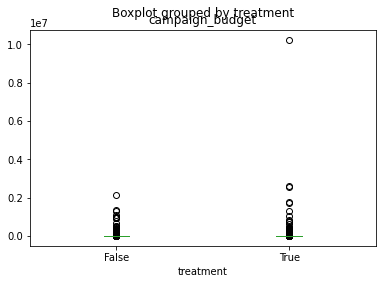

In [22]:
df.boxplot(by ='treatment', column =['campaign_budget'], grid = False) 


In [23]:
# df_mod will be the dataframe that excludes the high budget outlier

df_treatment.sort_values(by='campaign_budget', ascending=False)
df.sort_values(by='campaign_budget', ascending=False)
df_mod = df.drop([12658])

df_mod_control = df_mod[df_mod['treatment']== False]
df_mod_test = df_mod[df_mod['treatment']== True]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


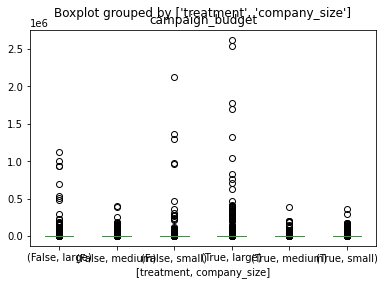

In [24]:
# without outlier
df_mod.sort_values(by='campaign_budget', ascending=False)
df_mod.boxplot(by =['treatment','company_size'], column =['campaign_budget'], grid = False) 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


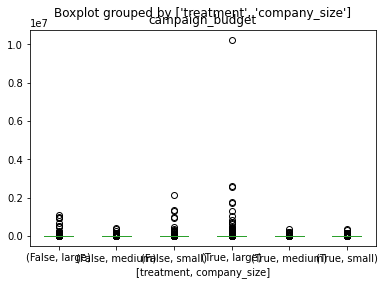

In [25]:
# with outlier
df.boxplot(by =['treatment','company_size'], column =['campaign_budget'], grid = False) 

In [26]:
## We get the same results with and without outlier included in the data

t1, p1 = ttest_ind(df_mod_control['campaign_budget'], df_mod_test['campaign_budget'])
p1 = p1/2
print('company size: all')
print("t = " + str(t1))
print("p = " + str(p1))

if p1 < alpha and t1 > 0:
  print('Reject null')
else:
  print('Fail to reject null')
print("")


df_control_dict = {}
df_test_dict = {}

for size, sub_df in df_mod_control.groupby('company_size'):
  df_control_dict[size] = sub_df

for size, sub_df in df_mod_test.groupby('company_size'):
  df_test_dict[size] = sub_df

for size in ['small', 'medium', 'large']:
  print('company size: ' + str(size))
  t2, p2 = ttest_ind(df_control_dict[size]['campaign_budget'], df_test_dict[size]['campaign_budget'])
  p2 = p2/2
  print("t = " + str(t2))
  print("p = " + str(p2))
  if p2 < alpha and t2 > 0:
    print('Reject null')
  else:
    print('Fail to reject null')
  print("")

company size: all
t = -1.0589778930738336
p = 0.1448131904585357
Fail to reject null

company size: small
t = 2.553323378723892
p = 0.005343284160711176
Reject null

company size: medium
t = 1.145686261065636
p = 0.12605867702155
Fail to reject null

company size: large
t = -3.2804208978169362
p = 0.0005217139832641337
Fail to reject null

